In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
import xarray as xr
import numpy as np
import os
import datetime
import shutil
import glob
import calendar
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tempfile
from PIL import Image

In [8]:
# List of month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

wind_data = '../datasets/data_t.nc'
current_data = '../datasets/cmems_obs-mob_glo_phy-cur_my_0.25deg_P1M-m_1740187181287.nc'
ssh_data = '../datasets/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D_1740483994742.nc'
sst_data = '../datasets/MUR_Monthly_SST_.nc'
sss_data = '../datasets/cmems_obs-mob_glo_phy-sss_my_multi_P1M_1740653508523.nc'

In [9]:
def computation(wind_data, var):
    
    dat = xr.open_dataset(wind_data, engine='netcdf4')
    dat = dat.sel(latitude=slice(2, 6))

    monthly_ekman = dat[var].resample(valid_time='1ME').mean()

    wind_stress_x = dat['wind_stress_x'].resample(valid_time='1ME').mean()
    wind_stress_y = dat['wind_stress_y'].resample(valid_time='1ME').mean()

    dat.close()

    return wind_stress_x, wind_stress_y, monthly_ekman

In [10]:
%%time
ekman_T = computation(wind_data, 'ekman_transport')

CPU times: total: 594 ms
Wall time: 1.55 s


In [15]:

def plot_ekman_with_wind(data_var, var2, unit, color):

    wind_stress_x, wind_stress_y, monthly_ekman = data_var

    fig, axs = plt.subplots(figsize=(15, 12), nrows=4, ncols=3, subplot_kw={"projection": ccrs.PlateCarree()})
    contour = None

    for month_index in range(12):
        ax = axs[month_index // 3, month_index % 3]

        ekman_month = monthly_ekman.sel(valid_time=monthly_ekman['valid_time'].dt.month == (month_index + 1)).mean(dim='valid_time')
        wind_x_month = wind_stress_x.sel(valid_time=wind_stress_x['valid_time'].dt.month == (month_index + 1)).mean(dim='valid_time')
        wind_y_month = wind_stress_y.sel(valid_time=wind_stress_y['valid_time'].dt.month == (month_index + 1)).mean(dim='valid_time')
        # curl = wind_stress_curl.sel(valid_time=wind_stress_curl['valid_time'].dt.month == (month_index + 1)).mean(dim='valid_time')

        # Contour plot for Ekman pumping or transfer
        contour = ekman_month.plot.contourf(ax=ax, cmap=color,add_colorbar=False, levels=np.linspace(ekman_month.min(), ekman_month.max(), 20))#, levels=800, add_colorbar=False)#, vmax=vmx, vmin=vmn)

        # Quiver plot for Wind Stress
        latitudes = monthly_ekman.latitude[::4]  
        longitudes = monthly_ekman.longitude[::4]
        wind_x = wind_x_month.sel(latitude=latitudes, longitude=longitudes)
        wind_y = wind_y_month.sel(latitude=latitudes, longitude=longitudes)
        wind_x = wind_x * 100  
        wind_y = wind_y * 100
        ax.quiver(longitudes, latitudes, wind_x, wind_y, scale=5, scale_units='xy', width=0.003, color='red', transform=ccrs.PlateCarree())

        ax.set_title(f'{month_names[month_index]}', fontsize=12)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')  
        ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='black')  
        ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
        ax.gridlines(draw_labels={"bottom": "x", "left": "y"})

   
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  
    # fig.colorbar(contour, cax=cbar_ax, orientation='vertical', label=f'{var2} {unit}')
    cbar = fig.colorbar(contour, cax=cbar_ax, orientation='vertical')
    cbar.set_label(f'{var2} {unit}', fontsize=14)  # Increase font size here

    #plt.suptitle(f'Monthly {var2}', y=0.9, fontsize=14)
    plt.savefig(f'../figures/{var2}_with_wind_stress.png')
    plt.show()
        

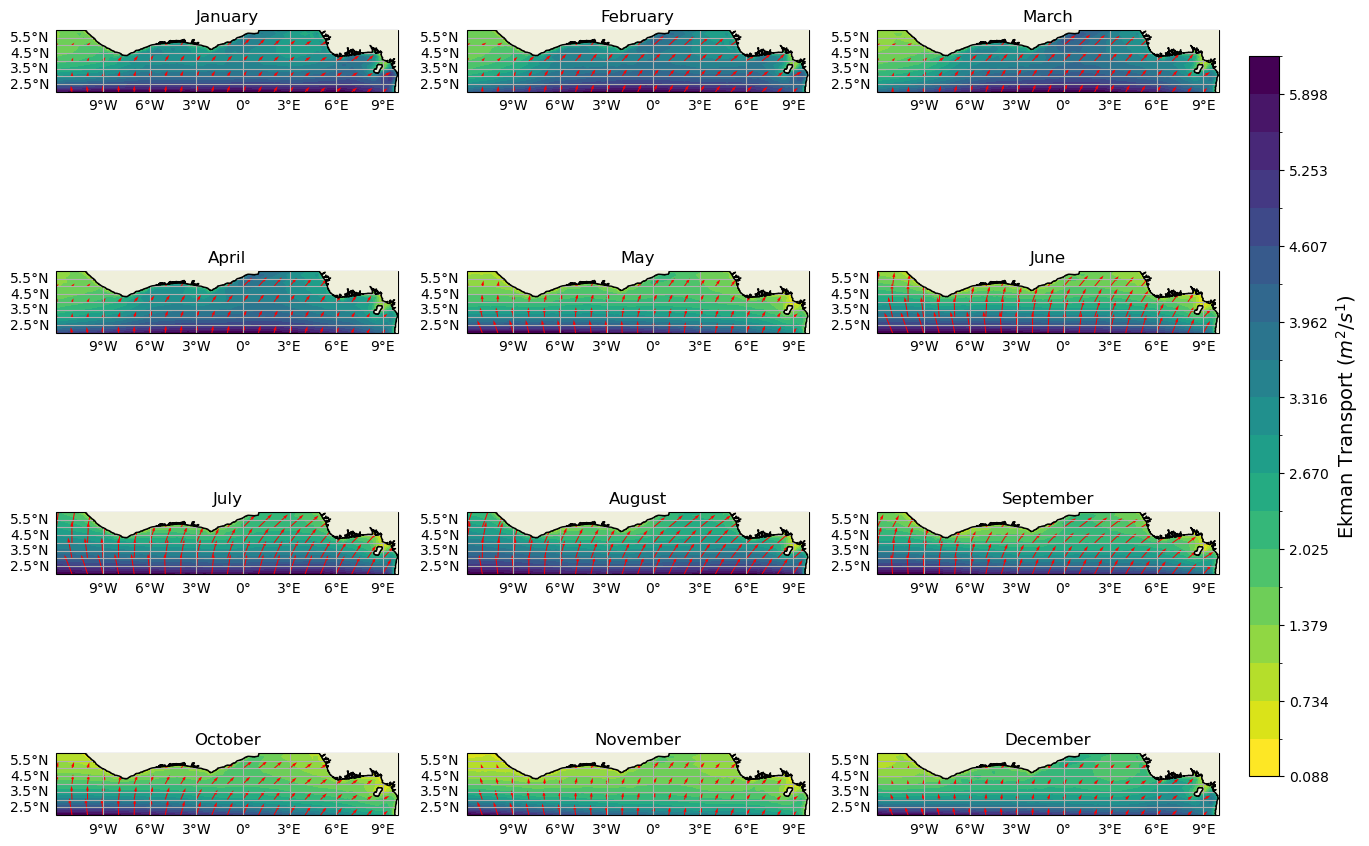

CPU times: total: 21.4 s
Wall time: 22.1 s


In [16]:
%%time
plot_ekman_with_wind(ekman_T, 'Ekman Transport', f'($m^2$/$s^1$)', 'viridis_r')